In [2]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

# dados de https://appeears.earthdatacloud.nasa.gov

In [3]:
def plot_burned_gdf(ax: plt.Axes, gdf: gpd.GeoDataFrame, simple: bool = False, legend=True):
    geod = Geod(ellps="WGS84")
    positive_normalized = gdf[gdf['value'] > 0]
    if simple:
        positive_normalized.plot(ax=ax, linewidth=0.0)
    else:
        positive_normalized.plot(column='value', ax=ax, cmap='Reds', linewidth=0.0, legend=legend)
    area = positive_normalized['geometry'].map(lambda geo: abs(geod.geometry_area_perimeter(geo)[0]))
    reference_burned_area = (area * positive_normalized['value']).sum() / 1000000
    ax.legend(title = "{:.2f}Km²".format(reference_burned_area), loc='lower left')

def compare_aqm_and_explore(aqm_gdf: gpd.GeoDataFrame, explore_df: pd.DataFrame, 
                            xmin = None, xmax = None, ymin = None, ymax = None, 
                            quadrat_width = 0.005, ax1: plt.Axes = None, 
                            ax2: plt.Axes = None, normatized: bool = False):
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True, sharex=True)
        fig.tight_layout()

    bounds = None if xmin is None else shapely.geometry.box(xmin, ymin, xmax, ymax)
    normalized = aqm_gdf if normatized else normalize_gdf(aqm_gdf, bounds, quadrat_width)
    plot_burned_gdf(ax1, normalized)

    cx.add_basemap(ax1, crs=normalized.crs.to_string())

    data_temp = explore_df if xmin is None else sub_space(explore_df, ymin, ymax, xmin, xmax)
    explorer = SatellitesExplore(data_temp, quadrat_width=quadrat_width, 
                                 burned_area_calc=polinomial_burned_area_calc(1, 10, 2),
                                 min_area_percentage=0.02,
                                 threshold_satellite=1)
    # explorer.show_satellites_areas(ax=ax2)
    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds')
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())

    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame(
        { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
        crs = burned.crs
    )
    evaluate = evaluate_gpd(normalized, temp)
    ax2.set_title(f"""ACC = {int(evaluate['ACC'] * 100)}%, CE = {int(evaluate['CE'] * 100)}%, OE = {int(evaluate['OE'] * 100)}%""")
    return (evaluate, normalized, temp)

In [4]:
def compare_aqm_and_explore_multiple(aqm_gdfs: list[gpd.GeoDataFrame], explore_dfs: list[pd.DataFrame], 
                                     xmin = None, xmax = None, ymin = None, ymax = None, 
                                     quadrat_width = 0.005, normatized: bool = False):
    size = len(aqm_gdfs)
    fig, axs = plt.subplots(size, 2, figsize=(25, size * 10), sharey=True, sharex=True)
    fig.tight_layout()
    for index, (aqm_file, explore_df) in enumerate(zip(aqm_gdfs, explore_dfs)):
        (ax1, ax2) = axs[index]
        data, aqm, explore = compare_aqm_and_explore(aqm_file, explore_df, xmin, xmax, ymin, ymax, 
                                       quadrat_width, ax1, ax2, normatized)
        time = explore_df.iloc[0]['datahora']
        ax1.set_title(f'Time: {time}')

In [5]:

def compare_values(values1: np.array, values2: np.array, n: int = 10, 
                   values1_label: str = 'Other', values2_label: str = 'Reference'):
    bins = np.linspace(0.0, 1.0, n)
    inds1 = np.digitize(values1, bins)
    inds2 = np.digitize(values2, bins)

    count = np.array([[np.min([np.sum(inds1 == i+1), np.sum(inds2 == j+1)]) for j in range(n)] for i in range(n)])

    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.flip(count, 0), cmap='viridis', extent=[0, 1, 0, 1], norm=colors.LogNorm(vmin=count.min(), vmax=count.max()))

    ax.set_xticks(np.linspace(0.0, 1.0, 5))
    ax.set_yticks(np.linspace(0.0, 1.0, 5))
    ax.set_xticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_yticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_xticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_yticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_ylabel(values1_label)
    ax.set_xlabel(values2_label)

    ax.grid(False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)


In [6]:
df = read_burn_df()
df.drop(["pais", "estado", "municipio", "bioma", "diasemchuva", "precipitacao", "regiao", "riscofogo", "frp"], axis=1, inplace=True)

In [7]:
# parametros escolhidos para a aplicação do AQ-FA
quadrat_width = 0.005
burned_area_calc = polinomial_burned_area_calc(1.5, 6.5, 2)
min_area_percentage=0.1
threshold_satellite=2

In [ ]:
import time
from datetime import datetime
from multiprocessing import Pool

hour = "14:00:00-03:00"

dt = pd.DataFrame(
    {
        'aqm30_file': [
            'LS8_AQM_221_067_20210719_0107', 'LS8_AQM_221_067_20210804_0107', 'LS8_AQM_221_067_20210820_0107',
            'LS8_AQM_221_067_20190628_0107', 'LS8_AQM_221_067_20190916_0107', 'LS8_AQM_221_067_20170724_0107',
            'LS8_AQM_222_067_20190923_0107', 'LS8_AQM_222_067_20160914_0107', 'LS8_AQM_220_065_20210829_0105',
            'LS8_AQM_220_065_20210525_0105', 'LS8_AQM_220_065_20191011_0105', 'LS8_AQM_220_065_20170919_0105'
        ],
    }
)

def validate(args) -> dict:
    aq30m_file, quadrat_width = args
    path, row, end_date = aq30m_file.split('_')[2:5]
    path, row, end_date, quadrat_width = int(path), int(row), datetime.strptime(end_date, '%Y%m%d'), float(quadrat_width)

    start = (end_date - timedelta(days=16)).strftime('%Y-%m-%d') + f' {hour}'
    end = end_date.strftime('%Y-%m-%d') + f' {hour}'

    region = get_landsat_geometry(path, row)
    aqm_gdf = gpd.read_file(f'tiff/{aq30m_file}')
    reference_area_km2 = aqm_gdf['km2'].sum()
    aqm_gdf = normalize_gdf(aqm_gdf, region, quadrat_width)
    explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
    explorer = SatellitesExplore(explore_df, 
                                 delimited_region=region,
                                 quadrat_width=quadrat_width, 
                                 burned_area_calc=burned_area_calc,
                                 min_area_percentage=min_area_percentage,
                                 threshold_satellite=threshold_satellite)
    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame({ 'value': burned['burned_factor'], 'geometry': burned['geometry'] }, crs=burned.crs)
    d = evaluate_gpd(aqm_gdf, temp)
    d['start_dt'] = start
    d['end_dt'] = end
    d['reference_area_km2'] = reference_area_km2
    d['model_area_km2'] = explorer.get_total_area_m_2() / 1000000
    d['orbita_ponto'] = '/'.join(aq30m_file.split('_')[2:4])
    return d

items = [np.append(*dt.iloc[i].values, quadrat_width) for i in range(len(dt))]

with Pool(6) as pool:
    values = pool.map(validate, items)
    dt = pd.concat([dt, pd.DataFrame(values)], axis=1)
    dt.to_csv(f'results/validate_results_{int(time.time())}.csv')
dt

In [8]:
wrs2: gpd.GeoDataFrame = gpd.read_file('tiff/grade_tm_am_do_sul')
estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')

join = gpd.sjoin(estados_shape, wrs2)
brasil_wrs2 = wrs2.iloc[join['index_right'].unique()]

/tmp/ipykernel_2955/4248809192.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: None

  join = gpd.sjoin(estados_shape, wrs2)


In [27]:
from multiprocessing import Pool

year = 2022

date_range = pd.date_range(f'{year}-01-01', periods=12, freq='M').insert(0, f'{year}-01-01')
date_pairs = [((start + timedelta(days=0 if i == 0 else 1)).strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')) 
              for i, (start, end) in enumerate(split_by_range_index(date_range))]

argss = [[brasil_wrs2.loc[index]['ORBITA'], brasil_wrs2.loc[index]['PONTO'], 
          f'{start} 00:00:00-03:00', f'{end} 23:59:59-03:00'] 
          for index in brasil_wrs2.T 
          for (start, end) in date_pairs]

def calculate(args) -> float:
    path, row, start, end = args
    path, row = int(path), int(row)
    file_name = f'''aq_fa/AQ-FA_{path}_{row}_{start.split(' ')[0]}_{end.split(' ')[0]}'''
    if os.path.exists(file_name): return 0.0
    print(f"Computing {file_name}...")
    try:
        region = get_landsat_geometry(path, row)
        explore_df = sub_space_by_landsat(df.query(f"'{start}' < datahora < '{end}'"), path, row)
        explorer = SatellitesExplore(explore_df, 
                                     delimited_region=region,
                                     quadrat_width=quadrat_width, 
                                     burned_area_calc=burned_area_calc,
                                     min_area_percentage=min_area_percentage,
                                     threshold_satellite=threshold_satellite)
        burned = explorer.get_burned_areas()
        temp = gpd.GeoDataFrame({ 'value': burned['burned_factor'], 'geometry': burned['geometry'] }, crs=burned.crs)
        if (len(temp[temp['value'] > 0]) > 0):
            temp[temp['value'] > 0].to_file(file_name)
        else:
            os.mkdir(file_name) # cria uma pasta vazia só pra marcar
        km2 = explorer.get_total_area_m_2() / 1000000
        del temp, explore_df, explorer, region, burned
        return km2
    except KeyboardInterrupt as error:
        raise error
    except Exception as error:
        print(f"ERROR {path}/{row}", error)
        raise error

print("Computing", len(argss), "values...")
values = []
with Pool(4) as pool:
    values = pool.map(calculate, list(argss[::-1]))

Computing 4584 values...
Computing aq_fa/AQ-FA_222_70_2022-12-01_2022-12-31...
Computing aq_fa/AQ-FA_222_70_2022-11-01_2022-11-30...
Computing aq_fa/AQ-FA_222_70_2022-10-01_2022-10-31...
Computing aq_fa/AQ-FA_222_70_2022-09-01_2022-09-30...
Computing aq_fa/AQ-FA_222_70_2022-08-01_2022-08-31...
Computing aq_fa/AQ-FA_222_70_2022-07-01_2022-07-31...
Computing aq_fa/AQ-FA_222_70_2022-06-01_2022-06-30...
Computing aq_fa/AQ-FA_222_70_2022-05-01_2022-05-31...
Computing aq_fa/AQ-FA_222_70_2022-04-01_2022-04-30...
Computing aq_fa/AQ-FA_222_70_2022-03-01_2022-03-31...
Computing aq_fa/AQ-FA_222_70_2022-02-01_2022-02-28...
Computing aq_fa/AQ-FA_222_70_2022-01-01_2022-01-31...
Computing aq_fa/AQ-FA_221_70_2022-12-01_2022-12-31...
Computing aq_fa/AQ-FA_221_70_2022-11-01_2022-11-30...
Computing aq_fa/AQ-FA_221_70_2022-10-01_2022-10-31...
Computing aq_fa/AQ-FA_221_70_2022-09-01_2022-09-30...
Computing aq_fa/AQ-FA_221_70_2022-08-01_2022-08-31...
Computing aq_fa/AQ-FA_221_70_2022-07-01_2022-07-31...
Com

In [26]:
def to_pretty_table_latex(dt: pd.DataFrame, columns: list[str], sort: list[str]) -> pd.Series:
    def print_item(column: str, item: any):
        if column == 'orbita_ponto':
            return "\\multirow{2}{*}{" + item + "}"
        elif column in ['start_dt', 'end_dt']:
            return datetime.strptime(item.split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
        elif column in ['reference_area_km2', 'model_area_km2']:
            return "${:.1f}Km^2$".format(item)
        elif column in ["B", "DC", "CSI"]:
            return "{:.2f}".format(item)
        elif isinstance(item, float):
            return "{:.2f}\\%".format(int(item * 10000) / 100)
        else:
            return str(item)

    def print_row(row):
        values = [print_item(columns[i], item) for i, item in enumerate(row)]
        values.insert(1, "")
        top = values[0::2]
        bottom = values[1::2]
        return " & ".join(top) + " \\\\\n" + " " * 24 + " & ".join(bottom) + " \\\\\n\\hline"
    
    return dt.sort_values(sort, ascending=False).loc[:, columns].apply(lambda row: print_row(row.values), axis=1)

dt = pd.read_csv("results/validate_results_1689518843.csv")
columns = ['orbita_ponto', 'start_dt', 'end_dt', 'ACC', 'CSI', 'CE', 'OE', 'B', 'DC', 'reference_area_km2', 'model_area_km2']
print('\n'.join(to_pretty_table_latex(dt, columns, ["DC"]).values))

\multirow{2}{*}{221/067} & 31/08/2019 & 97.14\% & 40.55\% & 1.20 & $1006.1Km^2$ \\
                         & 16/09/2019 & 0.48 & 28.49\% & 0.65 & $1210.3Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 04/08/2021 & 98.46\% & 45.37\% & 1.15 & $469.0Km^2$ \\
                         & 20/08/2021 & 0.41 & 37.16\% & 0.58 & $539.5Km^2$ \\
\hline
\multirow{2}{*}{220/065} & 13/08/2021 & 94.47\% & 55.09\% & 1.49 & $1317.3Km^2$ \\
                         & 29/08/2021 & 0.37 & 33.16\% & 0.54 & $1962.0Km^2$ \\
\hline
\multirow{2}{*}{222/067} & 07/09/2019 & 96.84\% & 63.26\% & 2.22 & $542.4Km^2$ \\
                         & 23/09/2019 & 0.34 & 18.40\% & 0.51 & $1202.3Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 19/07/2021 & 98.84\% & 56.09\% & 1.30 & $271.8Km^2$ \\
                         & 04/08/2021 & 0.33 & 43.03\% & 0.50 & $352.7Km^2$ \\
\hline
\multirow{2}{*}{221/067} & 03/07/2021 & 98.97\% & 54.32\% & 1.04 & $257.6Km^2$ \\
                         & 19/07/2021 & 0.30 & 52.48\% & 0.47 & $267.9Km^

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


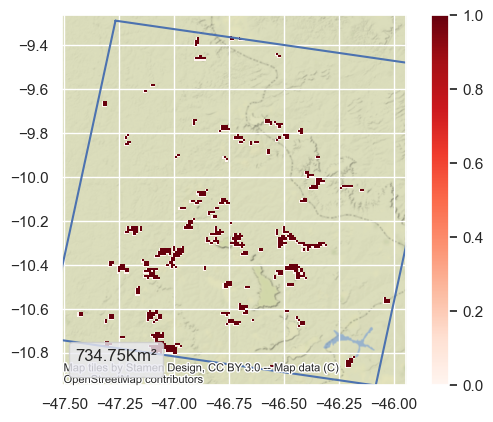

In [120]:
aq1km_gdf = normalize_gdf(gpd.read_file('tiff/aq1km/shp/2021_06_01_aq1km_V6.zip'), geometry, quadrat_width)
ax = plt.gca()
plot_burned_gdf(ax, aq1km_gdf)
cx.add_basemap(ax, crs=aq1km_gdf.crs.to_string())
ax.plot(*geometry.exterior.xy)

In [17]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdf = gpd.read_file('tiff/LS8_AQM_221_067_20210719_0107')
reference_area_km2 = aqm_gdf['km2'].sum()
aqm_gdf = normalize_gdf(aqm_gdf, geometry, quadrat_width)
explore_df = sub_space_by_landsat(df.query("'2021-07-03 14:00:00-03:00' < datahora < '2021-07-19 14:00:00-03:00'"), path, row)

explorer = SatellitesExplore(explore_df, 
                             delimited_region=geometry,
                             quadrat_width=quadrat_width, 
                             burned_area_calc=burned_area_calc,
                             min_area_percentage=min_area_percentage,
                             threshold_satellite=threshold_satellite)
xmin, ymin, xmax, ymax = geometry.bounds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
fig.tight_layout()

plot_burned_gdf(ax1, aqm_gdf, legend=False)
configure_geografic_axes(ax1, xmin, xmax, ymin, ymax)
cx.add_basemap(ax1, crs=aqm_gdf.crs.to_string())
ax1.plot(*geometry.exterior.xy)
ax1.set_title('AQ30m')
ax1.legend(title = "{:.2f}Km²".format(reference_area_km2), loc='lower left')

explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds', with_color_bar=False)
configure_geografic_axes(ax2, xmin, xmax, ymin, ymax)
cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
ax2.plot(*geometry.exterior.xy)
ax2.set_title('AQ-FA')

fig.savefig(os.path.join(image_folder, 'validacao_221_67.pdf'), bbox_inches="tight")

HTTPError: HTTP Error 403: Forbidden

<Axes: xlabel='value', ylabel='value'>

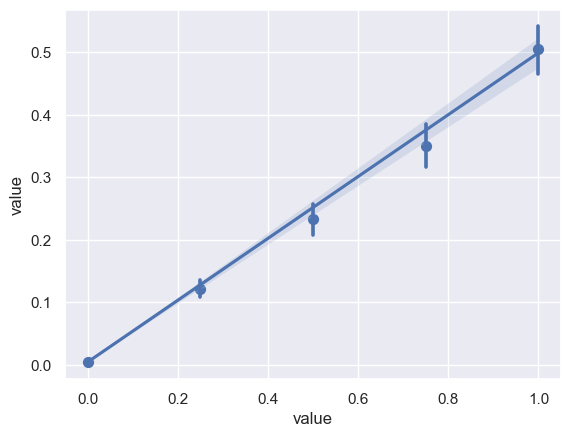

In [167]:
burned = explorer.get_burned_areas()
temp = gpd.GeoDataFrame(
    { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
    crs = burned.crs
)
ax = plt.gca()
sns.regplot(x=aqm_gdf['value'], y=temp['value'], x_bins=[0.0, 0.25, 0.50, 0.75, 1])
# sns.jointplot(x=aqm_gdf['value'], y=temp['value'], kind='reg')


In [57]:
import mapclassify
fj5 = mapclassify.StdMean(burned["value"])
fj5

StdMean

   Interval       Count
-----------------------
( -inf, -2.56] |      0
(-2.56, -1.17] |      0
(-1.17,  1.61] | 105905
( 1.61,  3.00] |   1543
( 3.00, 55.72] |   2354

In [37]:
import mapclassify
import numpy as np

class BurnedAreaCalcWrapper:

    def __init__(self, classifierBuilder, **kargs):
        self.classifierBuilder = classifierBuilder
        self.kargs = kargs
        self.hist = None

    def invoke(self, value: float, values: np.ndarray) -> float:
        if self.hist is None:
            self.hist = self.classifierBuilder(values, **self.kargs)
            self.min_range = self.hist.bins[int(len(self.hist.bins)/2) - 1]
            self.max_range = self.hist.bins[int(len(self.hist.bins)/2)]
            print(self.min_range, self.max_range)
            self.value_range = (self.max_range - self.min_range)
        return min(1, max(0, (value - self.min_range) / self.value_range))


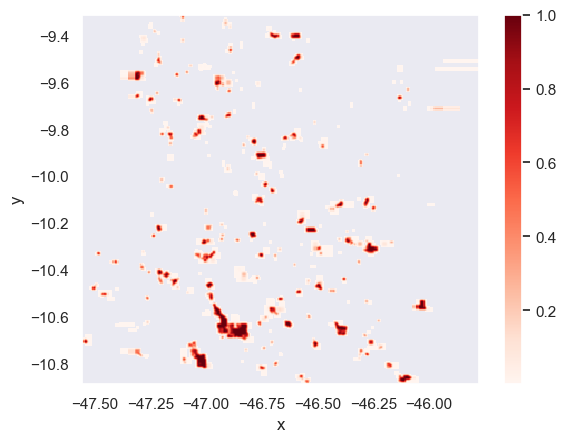

In [133]:
import cv2

temp = gpd.GeoDataFrame(
    { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
    crs = burned.crs
)
dataarray = create_dataarray(temp)
# kernel = np.array([
#     [0   ,1/16, 1/8, 1/16, 0   ],
#     [1/16, 1/8, 1/4, 1/8, 1/16],
#     [1/8 , 1/6, 1/2, 1/6, 1/8 ],
#     [1/16, 1/8, 1/6, 1/8, 1/16],
#     [0   ,1/16, 1/8,1/16, 0   ],
# ])
kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8,  1/4, 1/8],
    [1/16, 1/8, 1/16],
])
dataarray.data = np.clip(cv2.filter2D(dataarray.fillna(0.0).to_numpy(), -1, kernel), 0.0, 1.0)
dataarray.where(dataarray > 0).plot(cmap='Reds')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


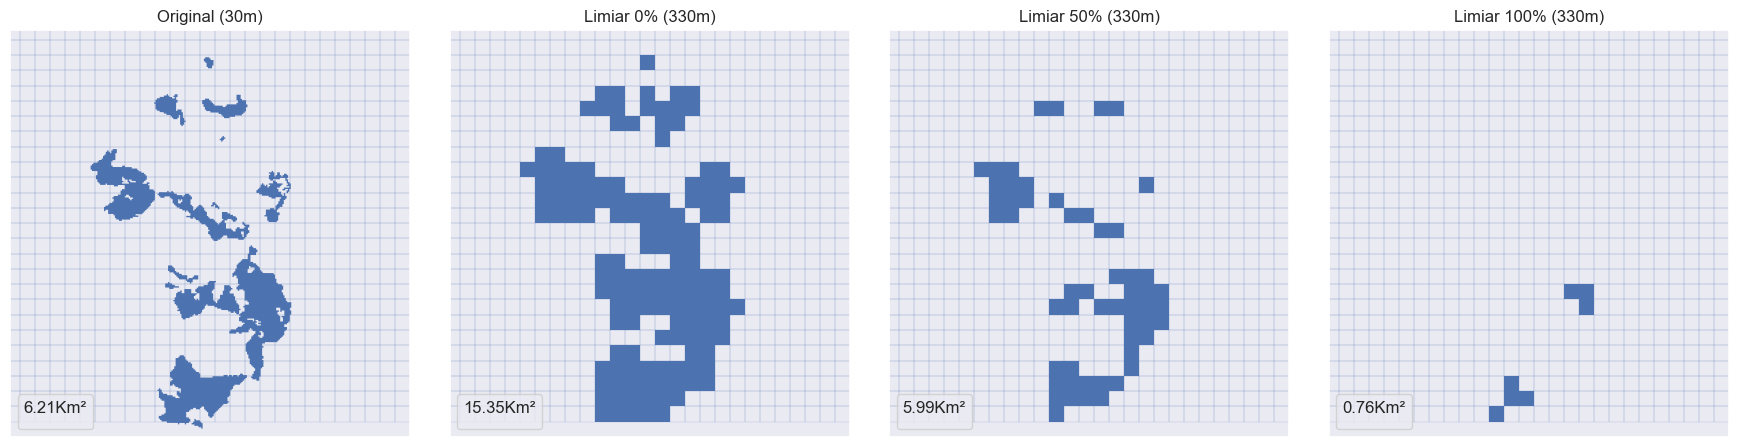

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


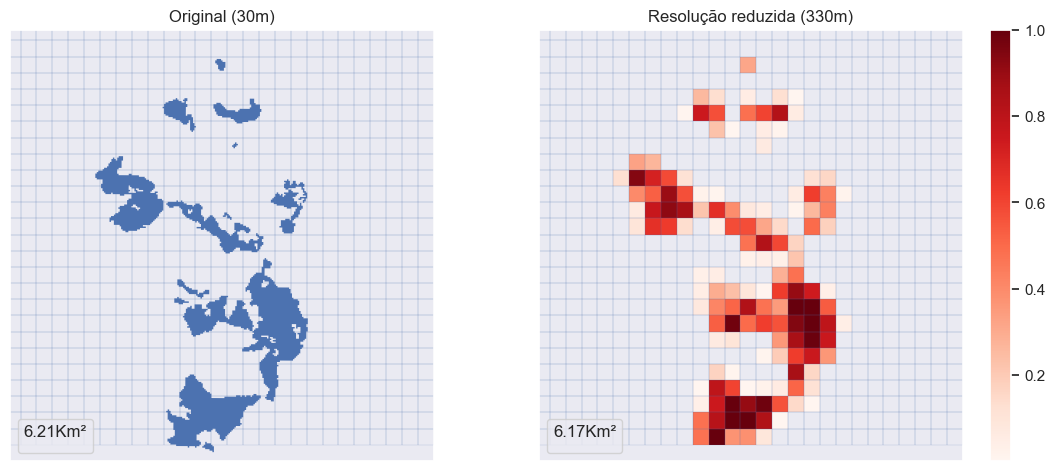

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")